In [1]:
import os
import random

from collections import defaultdict
from tensorflow import keras
from keras import Sequential, layers, optimizers, losses, activations, utils, saving
from sklearn.metrics import confusion_matrix

import scipy.io.wavfile as wav
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import seaborn as sns
import soundcard as sc
import soundfile as sf

2025-11-17 11:29:09.815965: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-11-17 11:29:09.835570: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-11-17 11:29:09.841906: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-11-17 11:29:09.860301: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
DATA_DIR = './Data/voices/recordings/'
SPEC_DIR_TRAIN = './Data/train/'
SPEC_DIR_TEST = './Data/test/'

In [3]:
'''
' PLEASE NOTE THAT THIS NOT MY CODE AND WILL FORM PART OF THE API
' THIS WAS ONLY USED FOR EASE OF TESTING AND WILL CHANGE AS MENTIONED ABOVE TO THE API
' URL TO DATASET: https://github.com/Jakobovski/free-spoken-digit-dataset
'''
def wav_to_spectrogram(audio_path, save_path, spectrogram_dimensions=(64, 64), noverlap=64, cmap='gray_r'):
    """ Creates a spectrogram of a wav file.

    :param audio_path: path of wav file
    :param save_path:  path of spectrogram to save
    :param spectrogram_dimensions: number of pixels the spectrogram should be. Defaults (64,64)
    :param noverlap: See http://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.spectrogram.html
    :param cmap: the color scheme to use for the spectrogram. Defaults to 'gray_r'
    :return:
    """

    sample_rate, samples = wav.read(audio_path)

    fig = plt.figure()
    fig.set_size_inches((spectrogram_dimensions[0]/fig.get_dpi(), spectrogram_dimensions[1]/fig.get_dpi()))
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    ax.specgram(samples, cmap=cmap, Fs=2, noverlap=noverlap)
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())
    fig.savefig(save_path, bbox_inches="tight", pad_inches=0)
    plt.close(fig) # Added for memory efficiency

import scipy

def trim_silence(audio, noise_threshold=450):
    """ Removes the silence at the beginning and end of the passed audio data

    :param audio: numpy array of audio
    :param noise_threshold: the maximum amount of noise that is considered silence
    :return: a trimmed numpy array
    """
    start = None
    end = None

    for idx, point in enumerate(audio):
        if abs(point) > noise_threshold:
            start = idx
            break

    # Reverse the array for trimming the end
    for idx, point in enumerate(audio[::-1]):
        if abs(point) > noise_threshold:
            end = len(audio) - idx
            break

    return audio[start:end]

def trim_silence_file(file_path, noise_threshold=450):
    """Accepts a file path, trims the audio and overwrites the original file with the trimmed version.

    :param file_path: file to trim
    :param noise_threshold: the maximum amount of noise that is considered silence
    :return: None
    """
    rate, audio = scipy.io.wavfile.read(file_path)
    trimmed_audio = trim_silence(audio, noise_threshold=noise_threshold)
    scipy.io.wavfile.write(file_path, rate, trimmed_audio)

In [9]:
'''
' Create dictionary of all files by speaker
' We want to split by speaker to ensure we have data for all speakers in training and testing datasets.
'''
speaker_files = defaultdict(list)

for file in os.listdir(DATA_DIR):
    parts = file.split('_')
    speaker = parts[1]
    speaker_files[speaker].append(file)

In [12]:
len(speaker_files['george'])

500

In [ ]:
'''
' Get a list of all files and split them equally for each speaker (70 / 30)
' Create Spectrograms from audio files for training and testing data.
'''

speaker_label_files = defaultdict(list)

for file in os.listdir(DATA_DIR):
    parts = file.split('_')
    label = parts[0]
    speaker = parts[1]
    speaker_label_files[(speaker, label)].append(file)

train_files = []
test_files = []


for (speaker, label), files in speaker_label_files.items():
    random.shuffle(files)
    idx = int(0.7 * len(files))
    train_files.extend(files[:idx])
    test_files.extend(files[idx:])

def ensure_label_dir(base, label):
    path = os.path.join(base, label)
    os.makedirs(path, exist_ok=True)
    return path

for audio_file in train_files:
    audio_path = os.path.join(DATA_DIR, audio_file)
    label = audio_file.split('_')[0]
    spec_path = ensure_label_dir(SPEC_DIR_TRAIN, label)
    spec_name = os.path.join(spec_path, audio_file[:-3] + "jpg")
    wav_to_spectrogram(audio_path, spec_name)

for audio_file in test_files:
    audio_path = os.path.join(DATA_DIR, audio_file)
    label = audio_file.split('_')[0]
    spec_path = ensure_label_dir(SPEC_DIR_TEST, label)
    spec_name = os.path.join(spec_path, audio_file[:-3] + "jpg")
    wav_to_spectrogram(audio_path, spec_name)

In [18]:
import os

base_path = "./Data"

# Loop through both train and test
for split in ["train", "test"]:
    print(f"\n[{split.upper()}]")
    split_path = os.path.join(base_path, split)
    
    # Loop through label folders (0–9)
    for label in sorted(os.listdir(split_path)):
        label_path = os.path.join(split_path, label)
        if os.path.isdir(label_path):
            num_samples = len(os.listdir(label_path))
            print(f"Label {label}: {num_samples} samples")


[TRAIN]
Label 0: 210 samples
Label 1: 210 samples
Label 2: 210 samples
Label 3: 210 samples
Label 4: 210 samples
Label 5: 210 samples
Label 6: 210 samples
Label 7: 210 samples
Label 8: 210 samples
Label 9: 210 samples

[TEST]
Label 0: 90 samples
Label 1: 90 samples
Label 2: 90 samples
Label 3: 90 samples
Label 4: 90 samples
Label 5: 90 samples
Label 6: 90 samples
Label 7: 90 samples
Label 8: 90 samples
Label 9: 90 samples


In [4]:
'''
' Create training and testing datasets.
' train_ds: Training dataset.
' test_ds: Testing dataset.
'''
train_ds = utils.image_dataset_from_directory(
  SPEC_DIR_TRAIN,
  seed = 123,
  image_size = (64, 64),
  batch_size = 25,
  label_mode = 'categorical'
)

test_ds = utils.image_dataset_from_directory(
    SPEC_DIR_TEST,
    seed = 123,
    image_size = (64, 64),
    batch_size = 25,
    label_mode = 'categorical'
)

Found 2100 files belonging to 10 classes.


I0000 00:00:1763371766.515268    3001 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:27:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1763371766.616361    3001 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:27:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1763371766.616430    3001 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:27:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1763371766.619779    3001 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:27:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1763371766.619875    3001 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:27:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

Found 900 files belonging to 10 classes.


In [5]:
for images, labels in train_ds.take(1):
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)

Images shape: (25, 64, 64, 3)
Labels shape: (25, 10)


2025-11-17 11:29:30.703469: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [6]:
class_names = train_ds.class_names
print(class_names)
print(len(class_names))

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
10


In [ ]:
'''
' Deep Learning Model.
' num_classes: Total number of classes. In this case 10 (0 - 9)
' Optimizer: AdamW
' Learning rate: 1e-5 (0.00001)
' Loss: CategoricalCrossentropy - For multilabel classification
' Final layer: Dense with num classes for units and softmax activation for multilabel classification
'''
num_classes = 10

model = Sequential()
model.add(layers.Input(shape = (64, 64, 3)))
model.add(layers.Rescaling(1./255))
model.add(layers.Conv2D(256, 3, activation = 'relu'))
model.add(layers.MaxPooling2D())
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.3))
model.add(layers.Conv2D(128, 3, activation = 'relu'))
model.add(layers.MaxPooling2D())
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.3))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation = 'relu'))
model.add(layers.Dense(128, activation = 'relu'))
model.add(layers.Dense(num_classes, activation = 'softmax'))

model.summary()

model.compile(optimizer = optimizers.AdamW(learning_rate = 1e-5), loss = losses.CategoricalHinge())
history = model.fit(train_ds, epochs = 50, batch_size = 25, validation_data = (test_ds))

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 62, 62, 256)    │         7,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 31, 31, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 31, 31, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 14, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,760,714 (25.79 MB)

 Trainable params: 6,759,946 (25.79 MB)

 Non-trainable params: 768 (3.00 KB)

Epoch 1/50


I0000 00:00:1763371782.420747    3261 service.cc:146] XLA service 0x7341e8006320 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1763371782.420913    3261 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 2070 SUPER, Compute Capability 7.5
2025-11-17 11:29:42.501303: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-11-17 11:29:42.810927: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


10/84 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1.1543

I0000 00:00:1763371787.207432    3261 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


84/84 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 1.1140 - val_loss: 1.0657
Epoch 2/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.8525 - val_loss: 1.3591
Epoch 3/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.5974 - val_loss: 1.6672
Epoch 4/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.4315 - val_loss: 1.7223
Epoch 5/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.3214 - val_loss: 1.7314
Epoch 6/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.2566 - val_loss: 1.5267
Epoch 7/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.2400 - val_loss: 1.2196
Epoch 8/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1883 - val_loss: 0.8825
Epoch 9/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1836 - val_loss: 0.6360
Epoch 10/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1408 - val_loss: 0.5154
Epoch 11/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1254 - val_loss: 0.4293
Epoch 12/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1127 - val_lo

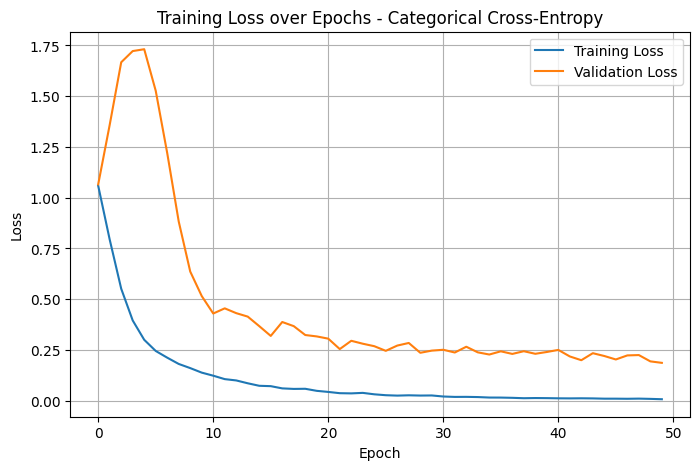

In [8]:
'''
' Plot training loss over epochs
'''
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize = (8, 5))
plt.plot(loss, label = 'Training Loss')
plt.plot(val_loss, label = 'Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs - Categorical Cross-Entropy')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
'''
' Take one batch of unseen test data and do predictions.
' test_ds: tensorflow dataset of spectrogram images.
'''
for images, labels in test_ds.take(1):
    predictions = model.predict(images)
    predicted_classes = np.argmax(predictions, axis = 1)
    true_classes = np.argmax(labels, axis = 1)

    correct = np.sum(predicted_classes == true_classes)
    total = len(true_classes)
    incorrect = total - correct
    accuracy = correct / total * 100

    print(f"Predicted classes: {predicted_classes}")
    print(f"True classes:      {true_classes}")
    print(f"Total samples:    {total}")
    print(f"Correct:          {correct}")
    print(f"Incorrect:        {incorrect}")
    print(f"Accuracy:         {accuracy}%")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step
Predicted classes: [3 6 1 6 6 3 1 6 1 4 5 2 6 4 9 5 3 7 2 5 3 1 5 2 7]
True classes:      [3 6 1 6 8 3 1 8 1 4 9 2 6 4 9 5 3 7 7 5 3 1 5 2 7]
Total samples:    25
Correct:          21
Incorrect:        4
Accuracy:         84.0%


2025-11-17 11:32:11.901346: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [10]:
'''
' Predict on All unseen test data.
' all_trues - All true labels of test data.
' all_preds - All predicted labels on test data.
'''
all_true = []
all_preds = []

for images, labels in test_ds:
    predictions = model.predict(images)
    predicted_classes = np.argmax(predictions, axis = 1)
    true_classes = np.argmax(labels, axis = 1)

    all_preds.extend(predicted_classes)
    all_true.extend(true_classes)

all_true = np.array(all_true)
all_preds = np.array(all_preds)


correct_t = np.sum(all_preds == all_true)
total_t = len(all_true)
incorrect_t = total_t - correct_t
accuracy_t = correct_t / total_t * 100

print(f"Predicted classes: {all_preds}")
print(f"True classes:      {all_true}")
print(f"Total samples:    {total_t}")
print(f"Correct:          {correct_t}")
print(f"Incorrect:        {incorrect_t}")
print(f"Accuracy:         {accuracy_t}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━

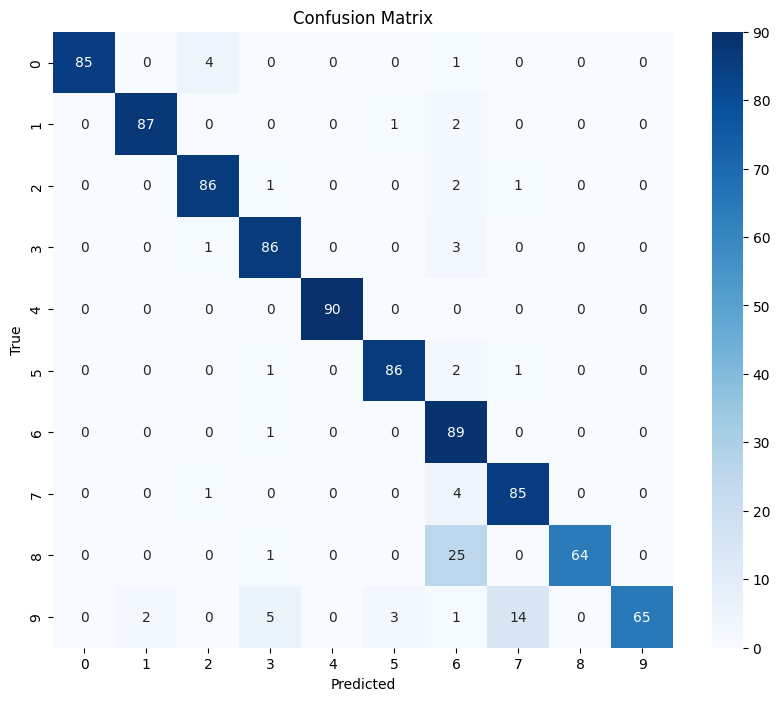

In [11]:
'''
' Confusion Matrix of Model Predictions on unseen test data.
'''

cm = confusion_matrix(all_true, all_preds)

plt.figure(figsize = (10, 8))
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues', xticklabels = test_ds.class_names, yticklabels = test_ds.class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
saving.save_model(model, './model_speech_classification_cnn.keras')